### The first step is in this project is to parse the desired stock data from the historical section of Yahoo finance.  This is done using BeautifulSoup.  Running the code requires the user to input a valid stock symbol that is listed in Yahoo finance.  The resulting data from the web are saved into a database using SQLite.

In [1]:
# !pip install BeautifulSoup

In [2]:
from bs4 import BeautifulSoup
import sqlite3 as sql
import urllib.request, urllib.parse, urllib.error

stock = input('Please enter valid stock symbol: ').upper()
url = "https://finance.yahoo.com/quote/" + stock + "/history?p=" + stock
html = urllib.request.urlopen(url).read()

soup = BeautifulSoup(html, "html.parser")

trs = soup.find_all('tr')

with sql.connect('stocks.db') as conn:
        cur = conn.cursor()
        cur.execute('DROP TABLE IF EXISTS stocks')
        cur.execute('CREATE TABLE stocks (Date int, Open_price int, High int, Low int, \
Closing int, Adj_close int, Volume int)')
        
for tr in trs:
    tds = tr.find_all('td')
    try:
        date = str(tds[0].get_text())
        open_price = str(tds[1].get_text())
        high = str(tds[2].get_text())
        low = str(tds[3].get_text())
        closing = str(tds[4].get_text())
        adj_close = str(tds[5].get_text())
        volume = str(tds[6].get_text())
    except:
        continue
    with sql.connect('stocks.db') as conn:
        cur = conn.cursor()
        cur.execute('INSERT INTO stocks (Date, Open_price, High, Low, Closing, Adj_close, Volume) \
        values (?,?,?,?,?,?,?)', (date, open_price, high, low, closing, adj_close, volume))
        conn.commit()

Please enter valid stock symbol: fb


### Since no error was given, we can safely assume the data has been saved to the database.  A quick import using pandas dataframe method can verify the stored data.  Since the date was entered into the database in text format, we can use the parse_date parameter and use the date column of the data to be parsed as the date.  Finally, the first five records of the database are displayed using the .head() function.

In [3]:
import pandas as pd
import numpy as np

connection = sql.connect('stocks.db')
result = pd.io.sql.read_sql('SELECT * FROM stocks', connection, parse_dates = ['Date'],
                           index_col='Date')
connection.close()
result.head(10)

,Open_price,High,Low,Closing,Adj_close,Volume
Date,,,,,,
2019-05-10,188.25,190.00,184.59,187.24,187.24,"7,958,939"
2019-05-09,187.20,189.77,186.26,188.65,188.65,"12,948,800"
2019-05-08,189.39,190.72,188.55,189.54,189.54,"12,505,700"
2019-05-07,192.54,192.90,187.85,189.77,189.77,"16,253,000"
2019-05-06,191.24,194.28,190.55,193.88,193.88,"13,994,900"
2019-05-03,194.38,196.16,193.71,195.47,195.47,"14,575,400"
2019-05-02,193.00,194.00,189.75,192.53,192.53,"13,209,500"
2019-05-01,194.78,196.18,193.01,193.03,193.03,"15,996,600"
2019-04-30,194.19,197.39,192.28,193.40,193.40,"23,494,700"


In [4]:
# Verify the type of object
type(result)

pandas.core.frame.DataFrame

In [5]:
result.dtypes

Open_price    float64
High          float64
Low           float64
Closing       float64
Adj_close     float64
Volume         object
dtype: object

### There are a rare occassional few stocks that value in the thousands which result in a comma in the data.  This data will be imported as a string making it hard to perform aggregations.  The following code will ensure commas are removed if this is the case.

In [6]:
try:
    result['Volume'] = result.Volume.str.replace(",", "").astype(int)
    result['Open_price'] = result.Open_price.str.replace(",", "").astype(float)
    result['High'] = result.High.str.replace(",", "").astype(float)
    result['Low'] = result.Low.str.replace(",", "").astype(float)
    result['Closing'] = result.Closing.str.replace(",", "").astype(float)
    result['Adj_close'] = result.Adj_close.str.replace(",", "").astype(float)
    print('All data converted to numeric form for analysis')
except:
    print('Imported data already in numeric form')

Imported data already in numeric form


In [7]:
# Verify the data types are now float and integers
result.dtypes

Open_price    float64
High          float64
Low           float64
Closing       float64
Adj_close     float64
Volume          int64
dtype: object

### Since all the data are now either float or integer values, we can use the describe() function to give overall statistics regarding the desired stock.

In [8]:
result.describe()

,Open_price,High,Low,Closing,Adj_close,Volume
count,100.000000,100.000000,100.000000,100.000000,100.000000,1.000000e+02
mean,163.277700,165.464100,161.544800,163.550100,163.550100,2.051375e+07
std,17.898495,17.353212,18.154441,17.811644,17.811644,1.147240e+07
min,123.100000,129.740000,123.020000,124.060000,124.060000,7.297400e+06
25%,148.080000,149.785000,146.330000,148.117500,148.117500,1.293860e+07
50%,165.490000,167.395000,163.815000,165.830000,165.830000,1.773990e+07
75%,175.312500,177.240000,174.447500,175.127500,175.127500,2.289928e+07
max,196.980000,198.480000,193.710000,195.470000,195.470000,7.723360e+07


### Aggregate functions will display similar results as statistical results.

In [9]:
print('HIGH')
print(result.High.agg([np.mean, np.min, np.max]))
print('LOW')
print(result.Low.agg([np.mean, np.min, np.max]))
print('CLOSING')
print(result.Closing.agg([np.mean, np.min, np.max]))

HIGH
mean    165.4641
amin    129.7400
amax    198.4800
Name: High, dtype: float64
LOW
mean    161.5448
amin    123.0200
amax    193.7100
Name: Low, dtype: float64
CLOSING
mean    163.5501
amin    124.0600
amax    195.4700
Name: Closing, dtype: float64


### Since visualizations are simpler to read compared to a dataframe of values, a boxplot can be used to visualize statistical values.  Using a boxplot, a reader can quickly determine the min, max, median as well as the first and third quartile.

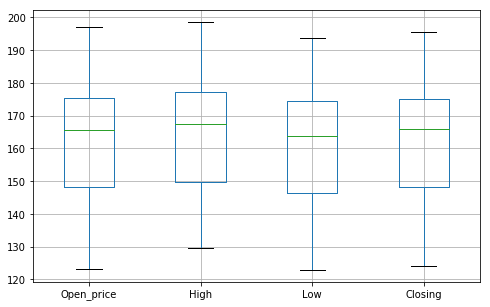

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
box = result[['Open_price', 'High', 'Low', 'Closing']]
box.boxplot(figsize=(8,5))

### To conclude the analysis, a line chart with the high and low are graphed together to visualize the trend for the last 6 months of data.

In [11]:
high = result['High']
low = result['Low']
closing = result['Closing']

Text(0,0.5,'Price in Dollars')

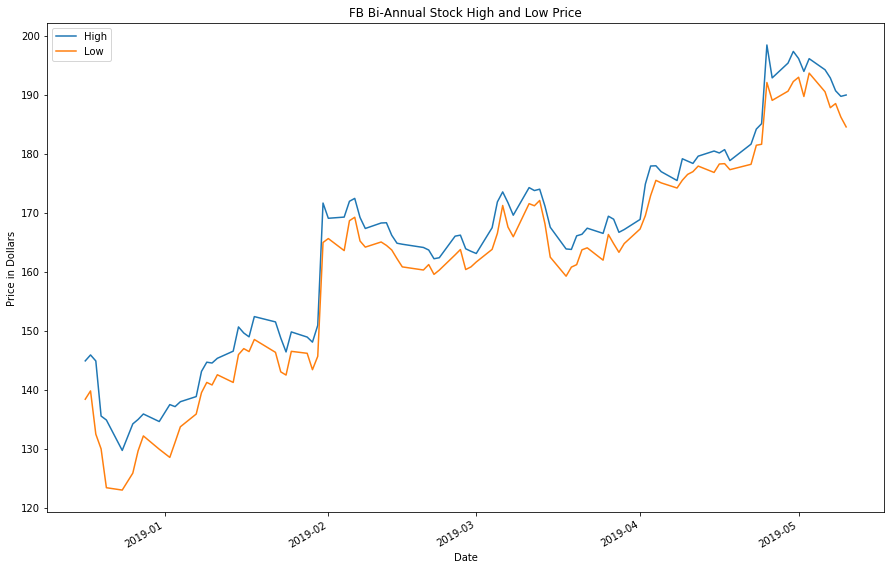

In [12]:
high.plot(figsize=(15,10))
low.plot(figsize=(15,10))
plt.legend(loc='upper left')
plt.title(stock + ' Bi-Annual Stock High and Low Price')
plt.xlabel('Date')
plt.ylabel('Price in Dollars')